In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
import os
from funciones import *
import scipy.misc 

In [62]:
#------------------------------------------------------------------------------------------------------
#                                 Trabajo Computacional 3
#------------------------------------------------------------------------------------------------------

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml('dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv('dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)
    
#Output folder:
outfolder='./resultados_fast_greedy/'

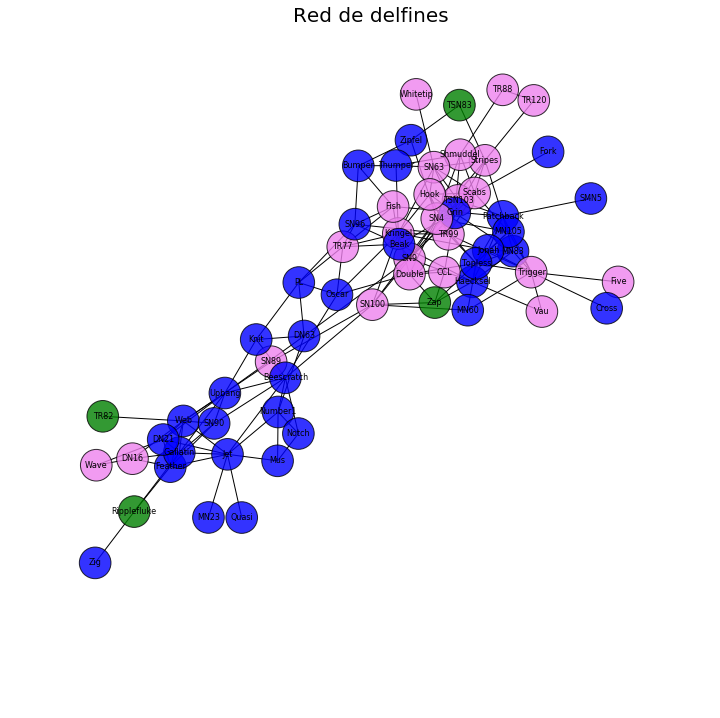

In [58]:
#------------------------------------------------------------------------------------------------------
#Grafico Original
#------------------------------------------------------------------------------------------------------
width=12
height=12
fig=plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')
pos = nx.spring_layout(mydolphins)

#Nodos
#nx.draw_networkx_nodes(mydolphins,pos,nodelist=mydolphins.nodes(),node_color=["blue" if g=='m' else "violet" if g=='f' else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()],with_labels=True,node_size=1000,alpha=0.8)
nx.draw_networkx_nodes(mydolphins,pos,nodelist=list(delfines),node_color=["blue" if g=='m' else "violet" if g=='f' else "green" for g in list(genero)],with_labels=True,node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Red de delfines',fontsize=20)
plt.axis('off')
plt.show()

In [63]:
#------------------------------------------------------------------------------------------------------
#Metodo: Fast Greedy
#------------------------------------------------------------------------------------------------------
comus = nx.algorithms.community.greedy_modularity_communities(mydolphins, weight=None)
comunidades=list(comus)
print(comunidades)

[frozenset({'SN9', 'Whitetip', 'TR88', 'Fork', 'Thumper', 'Zipfel', 'SN63', 'Scabs', 'Bumper', 'TSN103', 'TSN83', 'SN4', 'Fish', 'Beak', 'TR120', 'Stripes', 'SN96', 'Shmuddel', 'TR77', 'Grin', 'Hook', 'Kringel', 'TR99'}), frozenset({'Oscar', 'TR82', 'Zig', 'Web', 'Quasi', 'Jet', 'DN21', 'Beescratch', 'Wave', 'Knit', 'Upbang', 'Mus', 'Notch', 'Number1', 'Gallatin', 'MN23', 'DN16', 'SN90', 'PL', 'DN63', 'Feather', 'Ripplefluke'}), frozenset({'CCL', 'MN60', 'Vau', 'Jonah', 'Five', 'MN105', 'MN83', 'Topless', 'Patchback', 'Cross', 'Haecksel', 'Trigger', 'SMN5', 'Double', 'Zap'}), frozenset({'SN89', 'SN100'})]


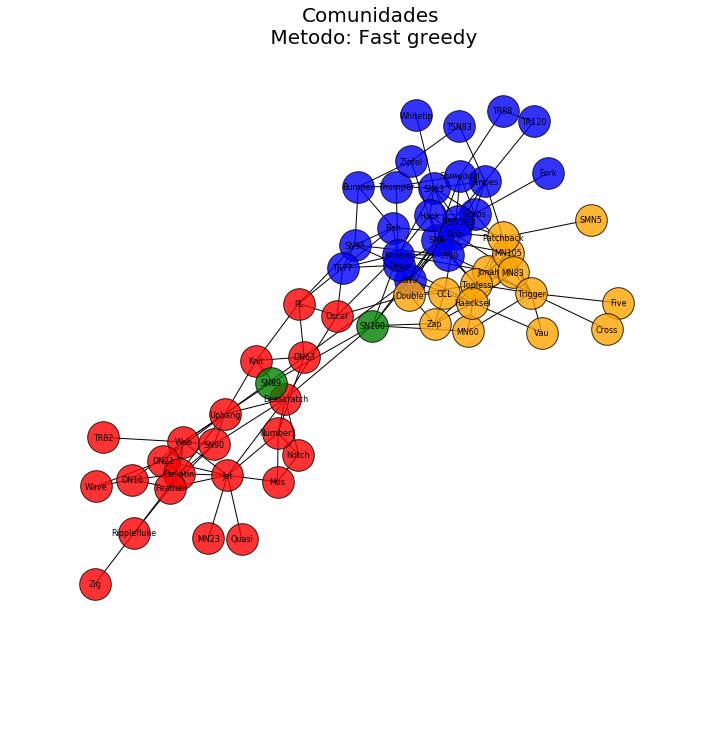

In [64]:
#------------------------------------------------------------------------------------------------------
#1.a)Visualice los resultados gráficamente
#------------------------------------------------------------------------------------------------------
colores=['blue','red','orange','green']
width=12
height=12
fig = plt.figure(figsize=(width, height))
fig.patch.set_facecolor('white')

#Nodos
for c,comu in enumerate(comunidades):
    nx.draw_networkx_nodes(mydolphins,pos,nodelist=comu,node_color=colores[c],node_size=1000,alpha=0.8)

#Enlaces
nx.draw_networkx_edges(mydolphins,pos,width=1.0,alpha=1)

#Etiquetas
nx.draw_networkx_labels(mydolphins,pos,font_size=8)
plt.title('Comunidades\n Metodo: Fast greedy',fontsize=20)
plt.axis('off')

plt.show()

In [65]:
#-------------------------------------------------------------------------------
#1.b) Modularidad y Silouhette:
#-------------------------------------------------------------------------------
#Asignamos a cada nodo del grafo la propiedad comunity que tendrá un color.

for c,comu in enumerate(comunidades):
    for delfin in list(comu):
        mydolphins.node[delfin]['comunity']=colores[c]
#-------------------------------------------------------------
#Modularidad:
#-------------------------------------------------------------
#Matriz de Adyacencias Aij:
delfines=mydolphins.nodes()
A = np.array(nx.to_numpy_matrix(mydolphins,nodelist=delfines))
N=mydolphins.number_of_nodes()
m=mydolphins.number_of_edges()
grado = dict(mydolphins.degree())

#Matriz de variable categorica comunidad: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):
        if mydolphins.nodes[idelfin]['comunity']==mydolphins.nodes[jdelfin]['comunity']:
            C[ni,nj]=1

#Calculo de la modularidad
#Q/Qmax=(S1-S2)*(1/2m)

#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0

for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[idelfin]*grado[jdelfin]*C[ni,nj]
S2=S2/(2*m)
mod=(S1-S2)/(2*m)

print('Modularidad = {0:.3f}'.format(mod))


Modularidad = 0.495


In [66]:
#Calculando la modularidad de cada comunidad:
modularidades=[]
for c,comu in enumerate(comunidades):
    s1=0
    s2=0
    for idelfin in list(comu):
        for jdelfin in list(comu):
            #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
            ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
            nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
            s1=s1+A[ni,nj]
            s2=s2+grado[idelfin]*grado[jdelfin]
    s2=s2/(2*m)
    mod=(s1-s2)/(2*m)
    modularidades.append(float(mod))

print('Modularidades por comunidad:')
print(modularidades)
print('Modularidad = {0:.3f}'.format(np.sum(modularidades)))

#Output
'''
output={}
output['color']=colores
output['mod']=modularidades
df=pd.DataFrame(output)
df.to_csv(outfolder+'modularidades.txt',sep='\t')
'''

Modularidades por comunidad:
[0.16877299157470038, 0.19271389581108342, 0.12851548593805623, 0.005488311380087813]
Modularidad = 0.495


"\noutput={}\noutput['color']=colores\noutput['mod']=modularidades\ndf=pd.DataFrame(output)\ndf.to_csv(outfolder+'modularidades.txt',sep='\t')\n"

Silhouette S[i]=
[('Oscar', -0.05172413793103444), ('CCL', -0.0217391304347826), ('Zipfel', 0.09565217391304355), ('TR82', -0.05172413793103444), ('Vau', 0.4299145299145299), ('Whitetip', 0.24223602484472057), ('Five', 0.3714285714285714), ('Quasi', 0.16666666666666666), ('TSN103', 0.08695652173913043), ('SN9', -0.23333333333333334), ('Zig', 0.2525252525252525), ('TR88', 0.24223602484472057), ('SN89', 0.8070175438596491), ('MN83', 0.3587878787878787), ('Jet', 0.20454545454545459), ('DN21', 0.27272727272727276), ('Fork', 0.23043478260869574), ('Zap', -0.16666666666666669), ('Thumper', 0.21739130434782608), ('Knit', 0.12727272727272734), ('Web', -0.13157894736842107), ('SN63', 0.30434782608695654), ('Upbang', 0.11363636363636365), ('Topless', 0.4604938271604939), ('Mus', 0.24242424242424235), ('Patchback', 0.2946666666666666), ('Notch', -0.035087719298245584), ('Cross', 0.3714285714285714), ('SN100', 0.7745098039215687), ('PL', 0.03141711229946514), ('Scabs', 0.29192546583850937), ('Bump

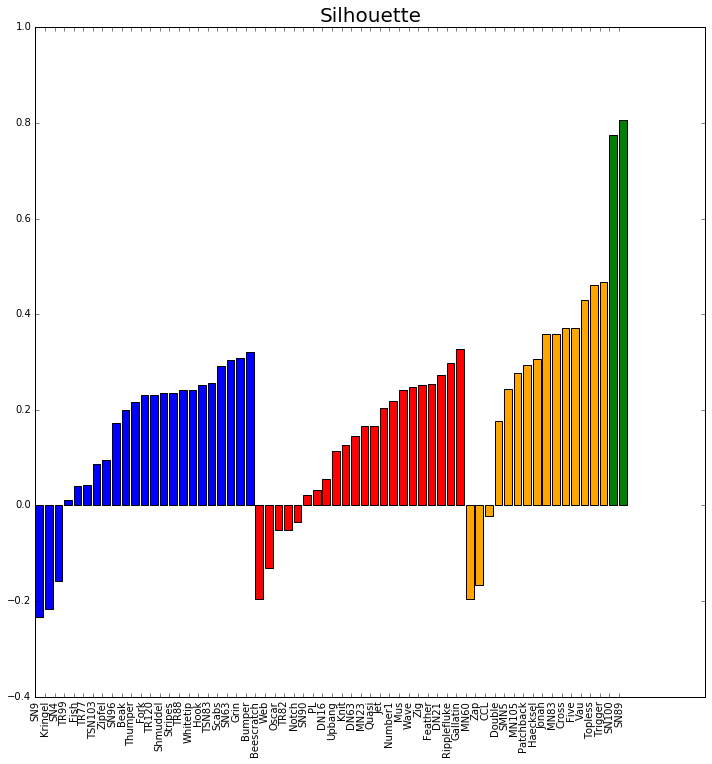

In [67]:
#-------------------------------------------------------------
#Silhouette:
#-------------------------------------------------------------
#distancia promedio de un nodo a todos los de su comunidad
#distancia se podria medir como el numero de links en el camino mas corto para llegar a otro.
#Ej:
#distancia entre 'Jet' y 'Trigger' = len(nx.shortest_path(mydolphins,'Jet','Trigger')) - 1

#Calculo de a[i]
a=[] #contendra para cada nodo en delfines la distancia promedio a nodos de su misma comunidad
for idelfin in delfines:
    distancias=[]
    for jdelfin in delfines:
        if mydolphins.nodes[idelfin]['comunity']==mydolphins.nodes[jdelfin]['comunity']:
               distancias.append(len(nx.shortest_path(mydolphins,idelfin,jdelfin))-1)         
    promedio=np.mean(distancias)
    a.append(promedio)

#Calculo de b[i]
b=[] #contendria para cada nodo en delfines la distancia promedio a nodos de otras comunidades, devuelvo  el promedio minimo
for idelfin in delfines: 
    #Me quedo con las comunidades distintas a la del delfin idelfin
    comuni=['blue','red','orange','green']
    comuni.remove(mydolphins.node[idelfin]['comunity'])
    b_comuni=[]
    for c in comuni:
        distancias=[]
        for jdelfin in delfines:
            if mydolphins.nodes[jdelfin]['comunity']==c:
                distancias.append(len(nx.shortest_path(mydolphins,idelfin,jdelfin))-1)
        promedio_comuni=np.mean(distancias)
        b_comuni.append(promedio_comuni)
    b.append(min(b_comuni))
    comuni=['blue','red','orange','green'] #vuelvo a comuni al inicial

#Calculo el Silhouette:
S=[]
for i,idelfin in enumerate(delfines):
    s=(b[i]-a[i])/(max(b[i],a[i]))
    S.append(s)
    #guardo la propiedad silhouette en el grafo:
    mydolphins.node[idelfin]['silhouette']=s
print('Silhouette S[i]=')
print (mydolphins.nodes.data('silhouette'))

#Output
'''
df = pd.DataFrame.from_dict(dict(mydolphins.nodes.data('silhouette')), orient="index")
df.to_csv(outfolder+'silhouette.txt',sep='\t')
'''

#Grafico de Silhouette:
width=12
height=12
plt.figure(figsize=(width, height))
delfines=np.sort(delfines)
x = []
xTicks = []
contador=-1
dtype = [('name', 'S21'), ('silhouette', float)]
for c in colores:
    delf_S=[] #lista con pares de [delfin,silouette]
    for i, idelfin in enumerate(delfines):
        if mydolphins.nodes[idelfin]['comunity']==c:
            delf_S.append((str(idelfin),mydolphins.nodes[idelfin]['silhouette']))        
    delf_S=np.array(delf_S,dtype=dtype)
    delf_S=np.sort(delf_S,order='silhouette') #lo ordeno segun la propiedad silhouette
    delf_S=list(delf_S)
    for j,d in enumerate(delf_S):
        contador=contador+1
        delfin=str(delf_S[j][0],'utf-8')
        silhouette_value=delf_S[j][1]
        plt.bar(contador,silhouette_value,color=mydolphins.nodes[delfin]['comunity'])#grafico una barra
        x.append(contador)
        xTicks.append(delfin)
plt.xticks(x, xTicks)
plt.xticks(range(len(delfines)),xTicks, rotation=90)
plt.title('Silhouette',fontsize=20)
plt.show()

In [54]:
#------------------------------------------------------------------------------
#1b) Rewirings:
#------------------------------------------------------------------------------
#Se podria tomar la red original recablear, y luego para las comunidades encontradas
#en la red original contar los enlaces que se hayan entre esos nodos.
#O sea estariamos calculando de forma simulada el valor kikj/2L.
#Haremos un histograma del numero de enlaces en esa comunidad.

#iteraciones=20000 #descomentar para que corra
Recableados={} #es un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','lc_real','lc_random'].
               #lc_random es una lista de tamano 'iteraciones' y que contiene el numero de enlaces dentro de esa comunidadn uno de esos recableados
lc_random=[[],[],[],[]]


#Recableamos y contamos enlaces en cada comunidad
for it in range(0,iteraciones):
    D=rewiring(mydolphins) #creamos un nuevo grafo recableado:
    D_ady = np.array(nx.to_numpy_matrix(D,nodelist=delfines))
    for c,comu in enumerate(comunidades):
        enlaces=0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
                nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces=enlaces+D_ady[ni,nj]
        lc_random[c].append(int(enlaces)/2)
        Recableados['comunidad'+str(c)]={'color':colores[c],'lc_real':0,'lc_random':list(lc_random[c])}

#Contamos enlaces en cada comunidad de la red original:
modularidad_rewiring
for c,comu in enumerate(comunidades):
        enlaces=0
        for idelfin in list(comu):
            for jdelfin in list(comu):
                #Buscamos los indices en la lista de delfines para luego acceder a la matrix de Ady con esos indices ni y nj:
                ni=[idx for idx,d in enumerate(delfines) if d==idelfin]
                nj=[idx for idx,d in enumerate(delfines) if d==jdelfin]
                enlaces=enlaces+A[ni,nj]
        enlaces=int(enlaces)/2
        Recableados['comunidad'+str(c)]['lc_real']=enlaces

#Graficamos:
'''
for c,comu in enumerate(comunidades):
    plt.figure(c)
    plt.hist(Recableados['comunidad'+str(c)]['lc_random'],color=colores[c],linewidth=1.5,edgecolor='black',label='Red recableada',alpha=0.8,normed=1)
    plt.axvline(x=Recableados['comunidad'+str(c)]['lc_real'],color=colores[c],linewidth=2,label='Red Real')
    plt.xlabel('$Numero$ $de$ $enlaces$ $dentro$ $de$ $la$ $comunidad$')
    plt.ylabel('$Frecuencia$')
    plt.legend(loc='upper center')
    plt.title('Modularidad '+' comunidad '+colores[c])
    plt.savefig(outfolder+'comunidad_'+colores[c]+'_hist.png')
'''    

#Output
'''
for c,comu in enumerate(comunidades):
    lc_real=Recableados['comunidad'+str(c)]['lc_real'] #numero de enlaces dentro de la comunidad en la red real
    lc_rewiring=np.mean(Recableados['comunidad'+str(c)]['lc_random'])#numero de enlaces promedio dentro de la comunidad para un cierto numero de redes recableadas.
    modularidad_por_rewiring=(lc_real-lc_rewiring)/m #dividimos por el numero de enlaces totales.
    output={}
    output['comunidad']=Recableados['comunidad'+str(c)]['color']
    output['enlaces_red_real']=lc_real
    output['enlaces_red_recabelada']=lc_rewiring
    output['modularidad por rewiring']=modularidad_por_rewiring
    output['modularidad por cuenta teorica']=modularidades[c]
    output['enlaces_red_random']=list(Recableados['comunidad'+str(c)]['lc_random'])
    df = pd.DataFrame.from_dict(output, orient="index")
    df.to_csv(outfolder+'comunidad_'+colores[c]+'_data.txt',sep='\t')
'''

NameError: name 'iteraciones' is not defined

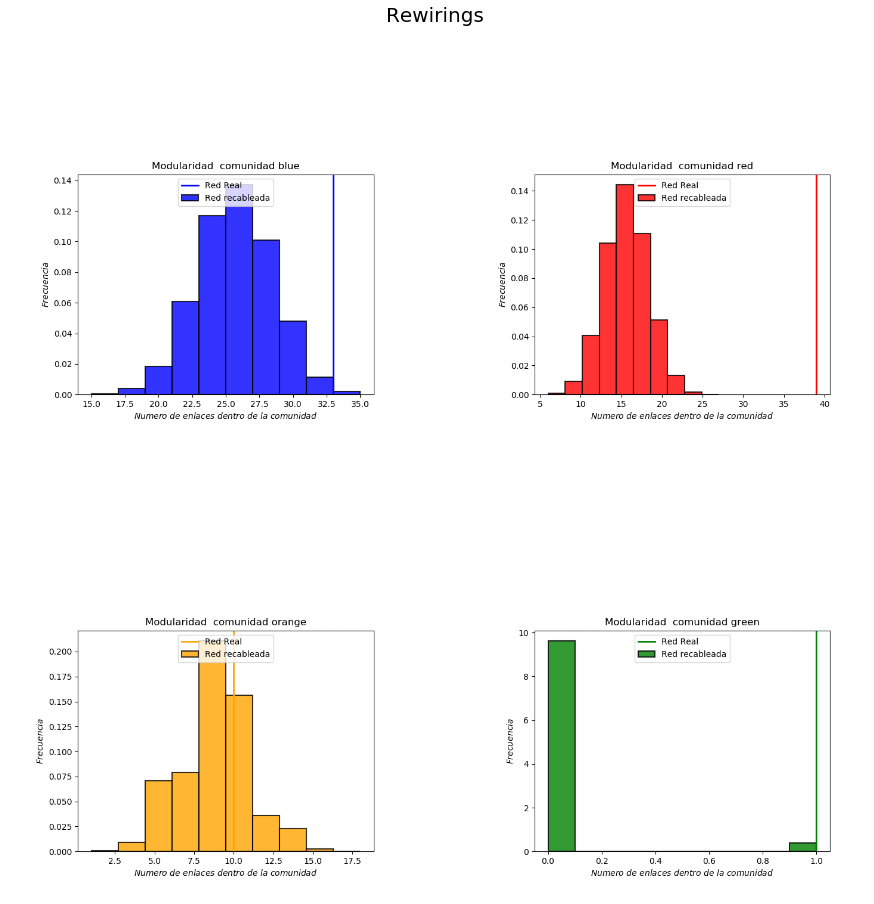

In [68]:
plt.figure(figsize=(15,15))
plt.suptitle('Rewirings',fontsize=20)
plt.subplot(2,2,1)
blue=plt.imread('resultados_fast_greedy/comunidad_blue_hist.png')
plt.imshow(blue)
plt.axis('off')

plt.subplot(2,2,2)
red=plt.imread('resultados_fast_greedy/comunidad_red_hist.png')
plt.imshow(red)
plt.axis('off')

plt.subplot(2,2,3)
orange=plt.imread('resultados_fast_greedy/comunidad_orange_hist.png')
plt.imshow(orange)
plt.axis('off')

plt.subplot(2,2,4)
green=plt.imread('resultados_fast_greedy/comunidad_green_hist.png')
plt.imshow(green)
plt.axis('off')

plt.show()

In [69]:
#Se hicieron 20000 recableados en cada red y en cada uno contamos la cantidad de enlaces dentro de cada comunidad:
#Los resultados estan en la carpeta resultados_fast_greedy.

enlaces_red_real=[33,39,10,1]
enlaces_red_rewiring=[25.2,15.7,8.8,0.038]#valor medio del histograma
modularidad_rewiring=[0.0489,0.146,0.007,0.006]


In [71]:
#-----------------------------------------------------------------------------------------------------------------------------
#1d)Tests de Fisher para ver la relacion entre genero y comunidades encontradas:
#-----------------------------------------------------------------------------------------------------------------------------
Generos={} #Es  un diccionario que tiene como keys ['comunidadi'] y como propiedades['color','dc','fc','mc','pFish','pvalor'].
           #dc: numero de delfines en la comunidad. 
           #fc: numero de hembras en la comunidad.
           #mc: numero de machos en la comunidad.
           #pFish: probabilidad de que hayan hc hembras en la comunidad por azar. pFish=(F fc)(N-F dc-fc)/(N dc)  donde (A a)=A!/a!(A-a)!
           #D: numero total de delfines
           #F: numero total de hembras
           #M: numero total de machos

delfinesF=[delfines[i] for i,idelfin in enumerate(delfines) if mydolphins.node[idelfin]['gender']=='f']
delfinesM=[delfines[i] for i,idelfin in enumerate(delfines) if mydolphins.node[idelfin]['gender']=='m']
F=len(delfinesF)
M=len(delfinesM)
D=M+F

for c,comu in enumerate(comunidades):
    dc=0
    fc=0
    mc=0
    for idelfin in list(comu):
        if mydolphins.node[idelfin]['gender']=='f':
            dc=dc+1
            fc=fc+1
        elif mydolphins.node[idelfin]['gender']=='m':
            dc=dc+1
            mc=mc+1
        else:
            mc=mc
            fc=fc
    pFish=scipy.misc.comb(F,fc)*scipy.misc.comb(N-F,dc-fc)/scipy.misc.comb(N,dc)
    #Calculo del pvalor:
    pvalor=0
    for f in range(fc,F+1):
        pvalor=pvalor+(scipy.misc.comb(F,f)*scipy.misc.comb(N-F,dc-f)/scipy.misc.comb(N,dc))
    Generos['comunidad'+str(c)]={'color':colores[c],'dc':dc,'fc':fc,'mc':mc,'pFish':pFish,'pvalor':pvalor}
    
#Output
'''
df = pd.DataFrame.from_dict(dict(Generos), orient="index")
df.to_csv(outfolder+'generos.txt',sep='\t')
'''


'\ndf = pd.DataFrame.from_dict(dict(Generos), orient="index")\ndf.to_csv(outfolder+\'generos.txt\',sep=\'\t\')\n'

In [24]:
Generos



{'comunidad0': {'color': 'blue',
  'dc': 22,
  'fc': 15,
  'mc': 7,
  'pFish': 0.0004808686644739319,
  'pvalor': 0.0005454008703263942},
 'comunidad1': {'color': 'red',
  'dc': 20,
  'fc': 2,
  'mc': 18,
  'pFish': 0.0010066311675111686,
  'pvalor': 0.9999042126329922},
 'comunidad2': {'color': 'orange',
  'dc': 14,
  'fc': 5,
  'mc': 9,
  'pFish': 0.23826990183603017,
  'pvalor': 0.7129994430418554},
 'comunidad3': {'color': 'green',
  'dc': 2,
  'fc': 2,
  'mc': 0,
  'pFish': 0.14595452141723955,
  'pvalor': 0.14595452141723955}}

In [72]:
dc=[22,20,14,2]#numero de delfines totales en cada comunidad
fc=[15,2,5,2]#numero de hembras en cada comunidad
mc=[7,18,9,0]#numero de machos en cada comunidadish
pFish=[0.00048,0.001,0.238,0.146]#probabilidad del test de Fischer
pvalor=[0.00054,0.999,0.713,0.146]#p-valor

tabla_resumen = pd.DataFrame({"Comunidades":["Blue","Red","Orange","Green"],
                    "Modularidad (teórica)":modularidades,
                    "Modularidad (rewiring)":modularidad_rewiring,
                    "Enlaces (red real)":enlaces_red_real,
                    "Enlaces (red rewiring)":enlaces_red_rewiring,
                    "Ndelfines":dc,
                    "Nhembras":fc,
                    "Nmachos":mc,
                    "pFischer":pFish,
                    "pValor":pvalor,
                   })
tabla_resumen

,Comunidades,Enlaces (red real),Enlaces (red rewiring),Modularidad (rewiring),Modularidad (teórica),Ndelfines,Nhembras,Nmachos,pFischer,pValor
0,Blue,33,25.200,0.0489,0.168773,22,15,7,0.00048,0.00054
1,Red,39,15.700,0.1460,0.192714,20,2,18,0.00100,0.99900
2,Orange,10,8.800,0.0070,0.128515,14,5,9,0.23800,0.71300
3,Green,1,0.038,0.0060,0.005488,2,2,0,0.14600,0.14600
